In [2]:
import env_32_e
import env_32_none
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from numpy import linalg as LA
from fitter import Fitter
import torch
path = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/SQSdrl/'
ind_1nn = np.load(path+'struc_info/ind_1nn.npy')
ind_2nn = np.load(path+'struc_info/ind_2nn.npy')
ind_3nn = np.load(path+'struc_info/ind_3nn.npy')
ind_4nn = np.load(path+'struc_info/ind_4nn.npy')
ind_raw = np.load(path+'struc_info/ind_raw32.npy')

In [ ]:
#*Deduce the average steps per episode for classical MC.
total_step, done_num = 1, 0
done_list, step_list = [], []
action_list = np.array([[i,j] for i, j in combinations(np.arange(32), 2)])
cr_, co_, ni_ = 1/3, 1/3, 1/3
eval_step = 100000

for i in range(eval_step):
    while True:
        ele_list = env_32_none.ele_list_gen(cr_, co_, ni_)
        ideal_cor = env_32_none.ideal_cor_func(cr_, co_, ind_1nn)
        cor_func = env_32_none.cor_func_all(ele_list)

        if cor_func > 30:
            break

    while True:
        a_ind = np.random.choice(range(len(action_list)))
        action = action_list[a_ind]
        ele_list_n, r, cor_func_n, _ = env_32_none.swap_step(
            action, ele_list, 8, step=1, ideal=ideal_cor)

        if cor_func_n < 8:
            done_num += 1
            total_step += 1
            break

        total_step += 1

    done_list.append(done_num)
    step_list.append(done_num/total_step)
    
    # if done_num % 100 == 0:
    #     clear_output(True)
    #     fig, ax = plt.subplots()
    #     ax.set_ylim([0.04, 0.08])
    #     plt.plot(done_list, step_list)
    #     plt.show()

print(done_num, total_step)

In [62]:
#find_overlap function from https://stackoverflow.com/questions/16970982/find-unique-rows-in-numpy-array/16973510#16973510
def find_overlap(A, B):

    if not A.dtype == B.dtype:
        raise TypeError("A and B must have the same dtype")
    if not A.shape[1:] == B.shape[1:]:
        raise ValueError("the shapes of A and B must be identical apart from "
                         "the row dimension")

    # reshape A and B to 2D arrays. force a copy if neccessary in order to
    # ensure that they are C-contiguous.
    A = np.ascontiguousarray(A.reshape(A.shape[0], -1))
    B = np.ascontiguousarray(B.reshape(B.shape[0], -1))

    # void type that views each row in A and B as a single item
    t = np.dtype((np.void, A.dtype.itemsize * A.shape[1]))

    # use in1d to find rows in A that are also in B
    return np.in1d(A.view(t), B.view(t))

#*Deduce the A and D matrix of 32-atom FCC cell.
#*Fix the original coordinates of atoms and embed them into a 32*1 list.
d_ele_1nn = np.zeros((32, 32))
a_ele_1nn = np.zeros((32, 32))
d_ele_1nn_power = np.zeros((32, 32))
for i in range(32):
    d_ele_1nn[i, i] = len([atom for atom in ind_1nn if (atom[0] == i or atom[1] == i)])
    d_ele_1nn_power[i, i] = d_ele_1nn[i, i]**(-1/2)
    for j in range(32):
        if (find_overlap(np.array([[i, j]]), ind_1nn)[0] == 1
        or find_overlap(np.array([[j, i]]), ind_1nn)[0] == 1):
            a_ele_1nn[i, j] = 1

In [30]:
#*L_tilt
l_ele_1nn = d_ele_1nn - a_ele_1nn
eig_val, eig_vec = LA.eig(l_ele_1nn)
l_1nn_tilt = 2*l_ele_1nn/np.max(eig_val)-np.identity(32)

In [72]:
a_tilt = d_ele_1nn_power@a_ele_1nn@d_ele_1nn_power + np.identity(32)

In [73]:
a_tilt = np.load('/media/wz/7AD631A4D6316195/Projects/SQS_drl/graph/fcc_32/a_tilt.npy')

{'norm': {'loc': 148.55528, 'scale': 14.540803420774246}}


,sumsquare_error,aic,bic,kl_div
norm,0.001886,1342.944923,-1.778621e+06,inf


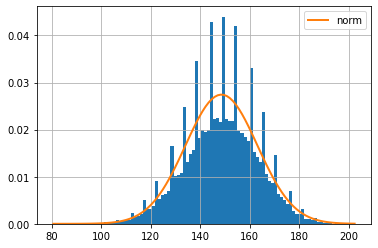

In [55]:
%matplotlib inline
valy_pair = np.array([round(i, 3) for i in res_list])
f_pair = Fitter(valy_pair, distributions = ['norm'], timeout = 1500)
f_pair.fit()

print(f_pair.get_best())
f_pair.summary()